In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

/usr/local/share/pynq-venv/lib/python3.8/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/usr/local/share/pynq-venv/lib/python3.8/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/usr/local/share/pynq-venv/lib/python3.8/site-packages/pynq/pl_server/xrt_device.py:59: UserWarning: xbutil failed to run - unable to determine XRT version
  warnings.warn("xbutil failed to run - unable to determine XRT version")


In [2]:
overlay.load_model("CNN_SVHN_KV260.xmodel")

In [3]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
%matplotlib inline
import xir

In [4]:
# graph= xir.Graph.deserialize("nuevo.xmodel")
# print(graph)



In [5]:
images_path= "/home/root/jupyter_notebooks/case_2024/datasets/svhn_images"
files= os.listdir(images_path)

In [6]:
def preprocess_fn(image_path, fix_scale):
    mean= [0.4376821, 0.4437697, 0.47286442]
    std= [0.19803012, 0.20101562, 0.19703614]
    image = cv2.imread(image_path)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image = image.reshape(32,32,3)
    image = image * (1/255.0)
    image= (image-mean)/std
    #image= image* fix_scale
    #image= image.astype(np.int8)
    return image

In [7]:
def desnorm(image):
    mean= [0.4376821, 0.4437697, 0.47286442]
    std= [0.19803012, 0.20101562, 0.19703614]
    image= image*std+mean
    return image

In [8]:
labels= []
for file in files:
    labels.append(file.split("_")[0])

In [9]:
# index= 0
# image_path= os.path.join(images_path, files[index])
# image = cv2.imread(image_path)

# mean= [0.485, 0.456, 0.406]
# std= [0.229, 0.224, 0.225]
# image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# #image = image.reshape(32,32,3)
# image = image * (1/255.0)
# image= (image-mean)/std
# image.max(), image.min()
# #plt.imshow(image)
# #print(labels[index])

In [10]:
index= 0
image_path= os.path.join(images_path, files[index])
#print(image_path)
img_pre= preprocess_fn(image_path, 64)
img_pre.shape

(32, 32, 3)

In [11]:
test_data= np.empty((len(files),32,32,3))
#test_data.shape
i=0
for file in files:
    
    image_path= os.path.join(images_path, file)
    img_pre= preprocess_fn(image_path, 64)
    test_data[i,...]= img_pre
    i+=1

In [12]:
test_data[0].shape

(32, 32, 3)

In [13]:
test_data.mean(), test_data.std()

(0.0322371132996414, 1.1369483087311032)

In [14]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

softmax = np.empty(outputSize)

In [15]:
shapeIn, shapeOut

((1, 32, 32, 3), (1, 10))

In [16]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

In [17]:
input_data[0].shape

(1, 32, 32, 3)

In [18]:
def calculate_softmax(data):
    result = np.exp(data)
    return result

In [19]:
test_data.shape

(25909, 32, 32, 3)

In [20]:
image[0,...] = test_data[0]

image.shape

(1, 32, 32, 3)

In [21]:
classes = ['zero', 'one' , 'two',
    'three', 'four', 'five',
    'six', 'seven', 'eight', 'nine']

clases_np= np.array(classes)

# test_label

In [22]:
test_data[1,:,:,:].shape

desnorm(test_data[1,:,:,:])

array([[[0.66666667, 0.64313725, 0.61568627],
        [0.66666667, 0.64313725, 0.61568627],
        [0.6627451 , 0.63921569, 0.61176471],
        ...,
        [0.61568627, 0.58823529, 0.57647059],
        [0.63921569, 0.60392157, 0.59215686],
        [0.65098039, 0.61568627, 0.60392157]],

       [[0.66666667, 0.64313725, 0.61568627],
        [0.66666667, 0.64313725, 0.61568627],
        [0.6627451 , 0.63921569, 0.61568627],
        ...,
        [0.6       , 0.57254902, 0.56078431],
        [0.62745098, 0.59215686, 0.58039216],
        [0.63921569, 0.60392157, 0.59215686]],

       [[0.65882353, 0.63529412, 0.60784314],
        [0.65882353, 0.63529412, 0.60784314],
        [0.65490196, 0.63137255, 0.60784314],
        ...,
        [0.57647059, 0.54509804, 0.53333333],
        [0.6       , 0.56470588, 0.55294118],
        [0.61176471, 0.57647059, 0.56470588]],

       ...,

       [[0.62352941, 0.6       , 0.57254902],
        [0.62352941, 0.6       , 0.57254902],
        [0.62745098, 0

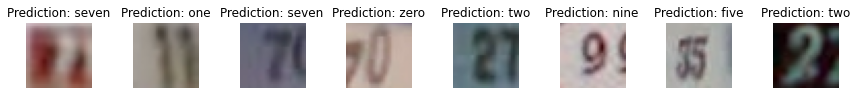

In [23]:
num_pics  = 8
fix, ax = plt.subplots(1, num_pics, figsize=(12,12))
plt.tight_layout()
for i in range(num_pics):
    
    image[0,...] = test_data[i]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    prediction = softmax.argmax()

    ax[i].set_title('Prediction: ' + classes[prediction])
    ax[i].axis('off')
    ax[i].imshow(desnorm(test_data[i,:,:,:]))

In [24]:
total = test_data.shape[0]
test_label=np.array(labels)
predictions = np.empty_like(test_label)
print("Classifying {} digit pictures ...".format(total))
correct=0
start = time()
for i in range(total):
    image[0,...] = test_data[i]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    predictions[i] = softmax.argmax()
    if classes[int(predictions[i])]==test_label[i]:
        correct+=1
stop = time()
#correct = np.sum(clases_np[predictions]==test_label)
execution_time = stop-start
print("Overall accuracy: {}".format(correct/total))
print("  Execution time: {:.4f}s".format(execution_time))
print("      Throughput: {:.4f}FPS".format(total/execution_time))

Classifying 25909 digit pictures ...
Overall accuracy: 0.9605928441854182
  Execution time: 10.5027s
      Throughput: 2466.8782FPS


In [26]:
def latency_measurement():
    image[0,...] = test_data[0]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    predictions  = softmax.argmax()

In [27]:
one_image_validation_time = %timeit -n 1 -o latency_measurement()

648 µs ± 383 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
one_image_validation_time.best

0.00037981300192768686

In [30]:
del overlay
del dpu